In [ ]:

!pip install -q datasets
from datasets import load_dataset

In [3]:
import numpy as np
import torch
import torchvision
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertConfig


In [4]:
class config:
    def __init__(self , image_size = 224, in_channels = 3 , patch_size = 16 , d_model = 768 , n_heads = 12, n_blocks = 12 ,  eps = 1e-6 , dropout = 0.1):

        self.image_size = image_size
        self.in_channels = in_channels
        self.patch_size = patch_size
        self.d_model = d_model
        self.n_heads = n_heads
        self.n_blocks = n_blocks
        self.eps = eps
        self.dropout = dropout

class PatchEmbeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.num_patches = (config.image_size // config.patch_size) ** 2
        self.patches = nn.Conv2d(in_channels=config.in_channels,
                                 out_channels=config.d_model,
                                 kernel_size=(config.patch_size, config.patch_size),
                                 stride=(config.patch_size, config.patch_size),
                                 padding="valid")
        self.pos_emb = nn.Embedding(self.num_patches, config.d_model)

    def forward(self, img):
        patches = self.patches(img)
        patch_emb = patches.flatten(2).transpose(1, 2)
        pos_ids = torch.arange(0, self.num_patches).unsqueeze(0).to(img.device)
        pos_embeddings = self.pos_emb(pos_ids)
        patch_embeddings = patch_emb + pos_embeddings
        return patch_embeddings

class MHA(nn.Module):
    def __init__(self , config):
        super().__init__()

        self.n_heads = config.n_heads
        self.d_k = config.d_model // config.n_heads
        self.scale = self.d_k ** 0.5

        self.w_q = nn.Linear(config.d_model , config.d_model)
        self.w_k = nn.Linear(config.d_model , config.d_model)
        self.w_v = nn.Linear(config.d_model , config.d_model)
        self.w_o = nn.Linear(config.d_model , config.d_model)

    def forward(self , Q , K , V):

        batch_size , n_seq , d_model = Q.size()

        Q = self.w_q(Q)
        K = self.w_k(K)
        V = self.w_v(V)

        Q = Q.view(batch_size , n_seq , self.n_heads , self.d_k).transpose(1,2)
        K = K.view(batch_size , n_seq , self.n_heads , self.d_k).transpose(1,2)
        V = V.view(batch_size , n_seq , self.n_heads , self.d_k).transpose(1,2)

        attention_scores = Q @ K.transpose(-2,-1) / self.scale
        attention_weights = torch.softmax(attention_scores , dim = -1)
        attention_values = attention_weights @ V
        attention_values_concat = attention_values.transpose(1,2).contiguous().view(batch_size , n_seq , d_model)

        attention_out = self.w_o(attention_values_concat)

        return attention_out

class MLP(nn.Module):
    def __init__(self , config):
        super().__init__()

        self.fc1 = nn.Linear(config.d_model , 4 * config.d_model)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(4 * config.d_model , config.d_model)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self , x):
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class ViTEncoder(nn.Module):
    def __init__(self , config):
        super().__init__()

        self.norm_1 = nn.LayerNorm(config.d_model , eps = config.eps)
        self.mha = MHA(config)
        self.norm_2 = nn.LayerNorm(config.d_model ,eps = config.eps)
        self.ffn = MLP(config)

    def forward(self , x ):
        residual = x
        x = self.norm_1(x)
        x = self.mha(x , x , x)
        x = residual + x

        residual = x
        x = self.norm_2(x)
        x = self.ffn(x)
        out = x + residual

        return out

class ViT(nn.Module):
    def __init__(self , config):
        super().__init__()

        self.patch_embeddings= PatchEmbeddings(config)
        self.layers = nn.ModuleList([ViTEncoder(config) for _ in range(config.n_blocks)])

    def forward(self , x):
        patch_embeddings = self.patch_embeddings(x)
        x = patch_embeddings
        for layer in self.layers:
            x = layer(x)
        return x




In [5]:
class CustomDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize((224, 224)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        caption = item['text']
        image = item['image']

        image = self.transform(image)

        inputs = self.tokenizer(caption, padding='max_length', truncation=True, max_length=64, return_tensors="pt")

        return {
            "image": image,
            "input_ids": inputs['input_ids'].squeeze(),
            "attention_mask": inputs['attention_mask'].squeeze()
        }

class TextEncoder(nn.Module):
    def __init__(self, proj_dim):
        super().__init__()
        self.model = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.proj = nn.Linear(768, proj_dim)
        self.layer_norm = nn.LayerNorm(proj_dim, eps=1e-6)

    def forward(self, tokens, attention_mask):
        text_emb = self.model(input_ids=tokens, attention_mask=attention_mask).last_hidden_state
        text_emb = text_emb[:, 0, :]
        text_proj = self.layer_norm(self.proj(text_emb))
        return text_proj

class ImageEncoder(nn.Module):
    def __init__(self, proj_dim):
        super().__init__()
        vit_config = config()
        self.model = ViT(vit_config)
        self.proj = nn.Linear(vit_config.d_model, proj_dim)
        self.layer_norm = nn.LayerNorm(proj_dim)

    def forward(self, img):
        image_emb = self.model(img)
        image_emb = image_emb[:, 0, :]
        img_proj = self.layer_norm(self.proj(image_emb))
        return img_proj

class CLIP(nn.Module):
    def __init__(self, temperature=0.7):
        super().__init__()
        self.image_encoder = ImageEncoder(256)
        self.text_encoder = TextEncoder(256)
        self.temperature = temperature

    def forward(self, img, tokens, attention_mask):
        img_logits = self.image_encoder(img)
        text_logits = self.text_encoder(tokens, attention_mask)

        img_logits = F.normalize(img_logits, dim=-1)
        text_logits = F.normalize(text_logits, dim=-1)

        logits = torch.matmul(img_logits, text_logits.t()) / self.temperature
        labels = torch.arange(logits.size(0)).to(logits.device)

        loss = (F.cross_entropy(logits, labels) + F.cross_entropy(logits.t(), labels)) / 2
        return logits, loss

# def train(model, dataloader, optimizer, scheduler, device, epochs=25):
#     model.train()
#     for epoch in range(epochs):
#         total_loss = 0
#         for batch in dataloader:
#             optimizer.zero_grad()

#             images = batch['image'].to(device)
#             tokens = batch['input_ids'].to(device)
#             attention_mask = batch['attention_mask'].to(device)

#             _, loss = model(images, tokens, attention_mask)

#             loss.backward()
#             optimizer.step()
#             scheduler.step()
#             total_loss += loss.item()

#         print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}")

#         if (epoch + 1) % 5 == 0:
#             torch.save(model.state_dict(), f"new_model_epoch_{epoch+1}.pt")
#             print(f"Model saved after epoch {epoch+1}")

#     torch.save(model.state_dict(), "model_final.pt")
#     print("Final model saved after training")

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ds = load_dataset("lambdalabs/naruto-blip-captions")
# train_dataset = CustomDataset(ds['train'])

# dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# model = CLIP().to(device)
# optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
# scheduler = CosineAnnealingLR(optimizer, T_max=len(dataloader) * 10, eta_min=1e-6)

# train(model, dataloader, optimizer, scheduler, device)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CLIP().to(device)
model.load_state_dict(torch.load("/content/new_model_epoch_25.pt", map_location=device, weights_only=True))
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def preprocess_multiple_texts(texts):
    input_ids = []
    attention_masks = []

    for text in texts:
        inputs = tokenizer(text, padding='max_length', truncation=True, max_length=64, return_tensors="pt")
        input_ids.append(inputs['input_ids'])
        attention_masks.append(inputs['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0).to(device)
    attention_masks = torch.cat(attention_masks, dim=0).to(device)

    return input_ids, attention_masks
def perform_inference(image_path, texts):

    image = preprocess_image(image_path)
    tokens, attention_mask = preprocess_multiple_texts(texts)
    image = image.repeat(tokens.size(0), 1, 1, 1)
    with torch.no_grad():
        logits, _ = model(image, tokens, attention_mask)

    similarity_scores = torch.nn.functional.softmax(logits, dim=1)
    return similarity_scores

image_path = "/content/images.jpg"
texts = ["A girl with green hair", "A boy with orange hair"]

print("Test with multiple texts:")
similarity_scores = perform_inference(image_path, texts)
print(f"Similarity scores: {similarity_scores}")

Test with multiple texts:
Similarity scores: tensor([[0.6898, 0.3102],
        [0.6898, 0.3102]], device='cuda:0')


Test with multiple images and texts:
Image 1 similarity scores:
  A boy with orange hair: 0.8816
  an old man with grey hair and a beard: 0.1184
Image 2 similarity scores:
  A boy with orange hair: 0.1003
  an old man with grey hair and a beard: 0.8997


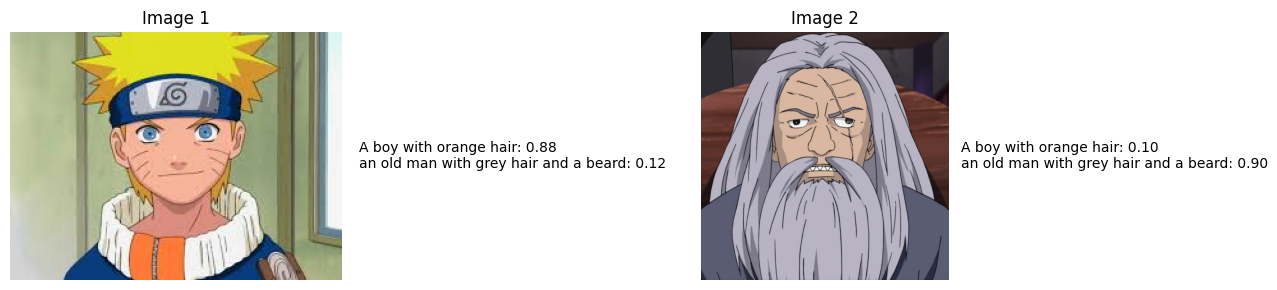

In [26]:
import torch
from torchvision import transforms
from PIL import Image
from transformers import DistilBertTokenizer
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CLIP().to(device)
model.load_state_dict(torch.load("/content/new_model_epoch_25.pt", map_location=device, weights_only=True))
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    return image

def preprocess_multiple_texts(texts):
    input_ids = []
    attention_masks = []

    for text in texts:
        inputs = tokenizer(text, padding='max_length', truncation=True, max_length=64, return_tensors="pt")
        input_ids.append(inputs['input_ids'])
        attention_masks.append(inputs['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0).to(device)
    attention_masks = torch.cat(attention_masks, dim=0).to(device)

    return input_ids, attention_masks

def perform_inference(image_path, texts):
    image = preprocess_image(image_path)
    tokens, attention_mask = preprocess_multiple_texts(texts)
    image = image.repeat(tokens.size(0), 1, 1, 1)

    logits, _ = model(image, tokens, attention_mask)

    similarity_scores = torch.nn.functional.softmax(logits, dim=1)
    return similarity_scores

def plot_multiple_images(image_paths, texts, similarity_scores_list):
    fig, axes = plt.subplots(1, len(image_paths), figsize=(14, 3))

    for i, image_path in enumerate(image_paths):
        image = Image.open(image_path)
        ax = axes[i] if len(image_paths) > 1 else axes

        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"Image {i+1}")

        scores = similarity_scores_list[i].squeeze().tolist()
        if isinstance(scores[0], list):
            scores = scores[0]

        text_output = "\n".join([f"{text}: {score:.2f}" for text, score in zip(texts, scores)])

        ax.text(1.05, 0.5, text_output, fontsize=10, verticalalignment='center', transform=ax.transAxes)

    plt.tight_layout()
    plt.show()

image_paths = ["/content/naruto.jpeg" , "/content/image (2).jpg"]
texts = [ "A boy with orange hair" , "an old man with grey hair and a beard"]

print("Test with multiple images and texts:")
similarity_scores_list = [perform_inference(image_path, texts) for image_path in image_paths]

for i, scores in enumerate(similarity_scores_list):
    print(f"Image {i+1} similarity scores:")
    scores_list = scores.squeeze().tolist()
    if isinstance(scores_list[0], list):
        scores_list = scores_list[0]
    for j, text in enumerate(texts):
        print(f"  {text}: {scores_list[j]:.4f}")

plot_multiple_images(image_paths, texts, similarity_scores_list)